# Contruyendo una CNN (Convolutional Neural Network)


In [1]:
!rm -r fashion-mnist
!unzip fashion-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png  
  inflating: fashion-mnist/test/0/645.png  
  inflating: fashion-mnist/test/0/34.png  
  inflating: fashion-mnist/test/0/716.png  
  inflating: fashion-mnist/test/0/3874.png  
  inflating: fashion-mnist/test/0/3128.png  
  inflating: fashion-mnist/test/0/2180.png  
  inflating: fashion-mnist/test/0/2439.png  
  inflating: fashion-mnist/test/0/269.png  
  inflating: fashion-mnist/test/0/2027.png  
  inflating:

## Se guardan las imagenes que se usaran en el training, valid y test sets en arreglos

In [2]:
from glob import glob
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

## Se colocan los datos aleatoriamente


In [3]:
import numpy as np
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

## Se organizan los datos anteriores en listas

In [4]:
from PIL import Image   # lee imagenes como arrays

# se cargan los datos del train set
N_train = len(train_files)
X_train, Y_train = [], []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

# se cargan los datos del valid set
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )
  
# se cargan los datos del test set
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) ) 

np.shape(X_train)  

(55000, 28, 28)

## Visualizando algunos datos

Objetos clasificados en 10 categorias así:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot



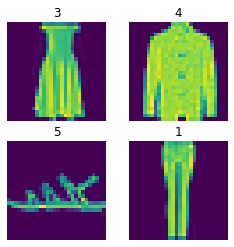

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*2])
  plt.title(Y_test[i*2])
  plt.axis(False)
plt.show()

## Convirtiendo a tensores de torch y copiandolos en la cpu


In [6]:
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

## Escogiendo el batch size y creando el TensorDataset y el DataLoader

In [7]:
import torch

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Creando la CNN

In [8]:
model = torch.nn.Sequential(
        # capa convolucional:
        torch.nn.Conv2d(1, 12, kernel_size=5, stride=1, padding=2),   # 1 solo canal pq son imagenes en blanco y negro, recibo 10 imagenes de ouput por cada 1 de entrada, uso un kernel cuadrado de 5x5, paso (stride) de 1 y borde de ceros de 2 de ancho
         # ( (28-5+2*2)/1 ) + 1 = 28   -> 28*28*12   -> se conserva el tamaño de la imagen de entrada * 10 kernels

        torch.nn.ReLU(),    # capa de activacion

        torch.nn.MaxPool2d(kernel_size=2),   
        # 28/2 = 14                 -> 14*14*12

        # parametro de regularizacion:
        torch.nn.Dropout(p=0.2),       # p: parametro de probabilidad:  20% de neuronas queda desactivadas

        torch.nn.Conv2d(12, 24, kernel_size=5, stride=1, padding=2),    # salen 24 canales
        # ( (14-5+2*2)/1 ) + 1 = 14   -> 14*14*24

        torch.nn.ReLU(),    # capa de activacion

        torch.nn.MaxPool2d(kernel_size=2),
        # 14/2 = 7                 -> 7*7*24

        torch.nn.Dropout(p=0.2), 

        torch.nn.Flatten(),    # capa de aplanado para pasar por la siguiente capa lineal:

        torch.nn.Linear(7*7*24, 10)    # entra el tamaño del espacio de configuracion, sale el numero de clases a clasificar
      )

model

Sequential(
  (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1176, out_features=10, bias=True)
)

## Representacion grafica de redes neuronales: usando libreria HiddenLayer

In [9]:
!pip install hiddenlayer

## Selecciono el dispositivo para usar la GPU

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Entrenamiento en GPU

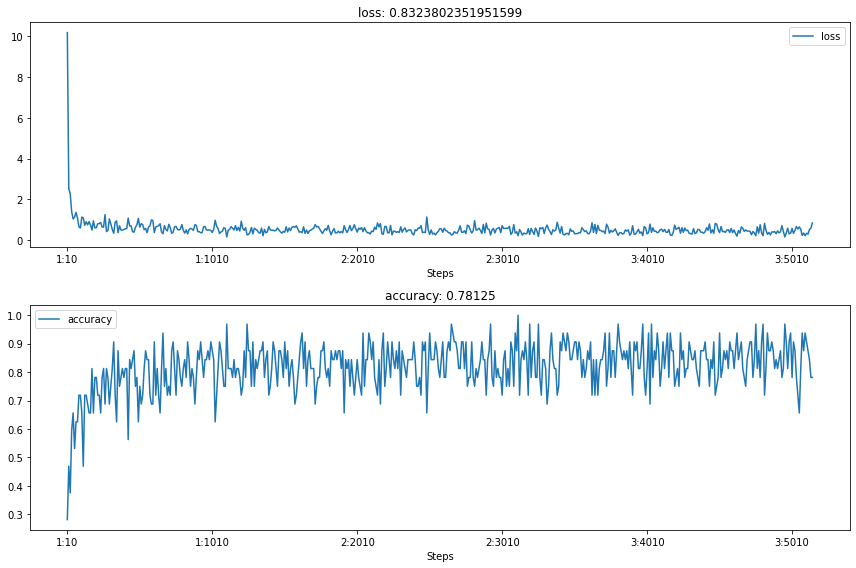

In [12]:
from sklearn.metrics import f1_score

# se carga el modelo en la GPU
model.to(device) 

# se definen el optimizador y criteria
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

n_epoch = 3

history = hl.History()   
canvas = hl.Canvas()      

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Se cargan los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()

    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch.cpu(), Y_pred.cpu(), average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        # Se visualiza la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])

## Mapa de caracteristicas

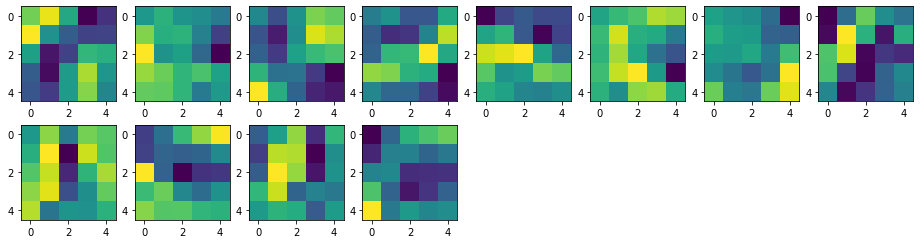

In [13]:
kernels = list(model.children())[0].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels.size(0)):
    plt.subplot(2,8,k+1)
    plt.imshow(kernels[i].squeeze().cpu())
    k += 1
plt.show()

## Evaluacion del modelo

In [18]:
Y_valid, X_valid = Y_valid.to(device), X_valid.to(device)

model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.40, F1:0.85, Acc:0.86


## Matriz de confusion y su grafica

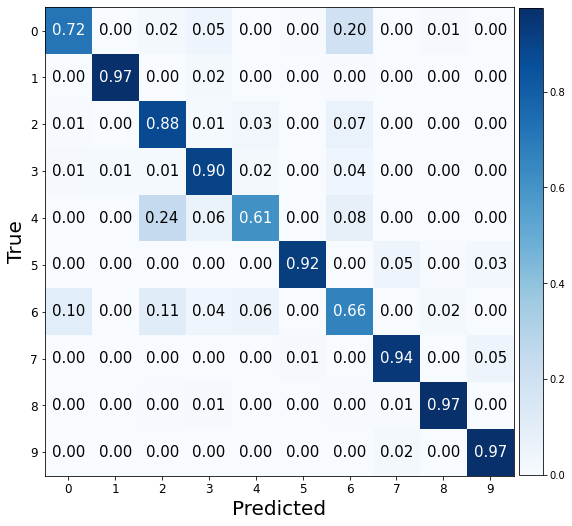

In [23]:
from sklearn.metrics import confusion_matrix
def CM(Y_true, Y_pred, classes: int):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true.cpu(), Y_pred.cpu())
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()  

CM(Y_valid, Y_pred, 10)  

# Reporte final

La CNN construida tiene 10 capas, en donde la primera y la quinta capa son capas convolucionales, y la penúltima es una capa de aplanado para poder la última capa ser lineal. En la siguiente figura se puede ver que después de pasar por la primera capa, se usa una función de activación ReLU, para luego hacer Max Pooling y reducir el número de características del modelo. Se reducen a la mitad estas caracteristicas con el kernel_size=2. Luego se usa una función de regularización para desactivar algunas neuronas y que el modelo aprenda más generalmente (dropout). En la siguiente capa es otra capa convulucional, de la cual salen 24 imagenes como output, se usa una funcion de activacion ReLU igualmente y se hace un Max Pooling en donde se reducen el numero de caracteristicas a 7. Se pasa todo esto por una capa de aplanado y luego por una capa lineal con output de dimension 10, por las 10 clases a clasificar por el modelo.

Los resultados obtenidos fueron un f1_score de 0.85, una perdida de 0.40 y una accuracy de 0.86. La matrix de convolucion se muestra en la celda de arriba. 

### Grafica de la estructura de mi red neuronal:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


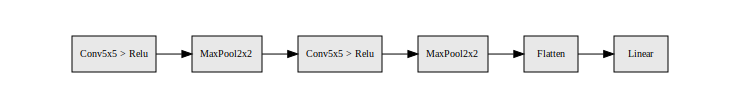

In [10]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([32,1,28,28]))